In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
# Retina 
%config InlineBackend.figure_format = 'retina'

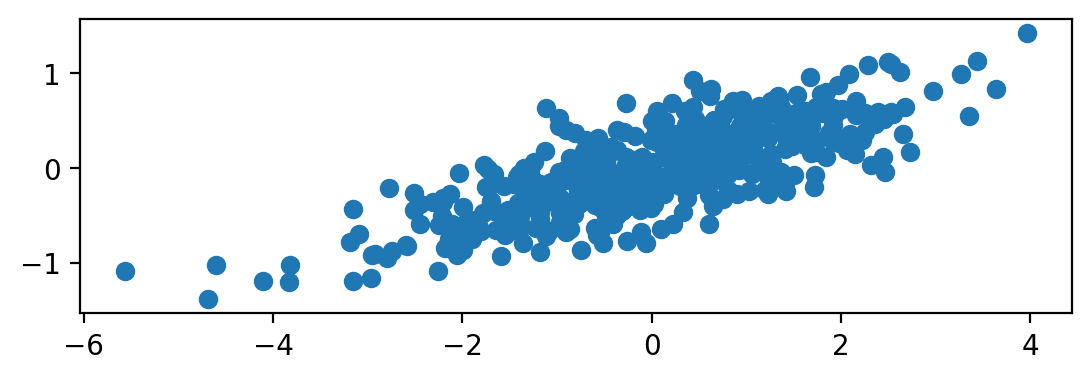

In [85]:
N = 500
D = 2

torch.manual_seed(1)
X = torch.distributions.MultivariateNormal(torch.zeros(D), torch.tensor([[2.0, 0.5], [0.5, 0.2]])).sample((N,))

X = X - X.mean(dim=0)
plt.scatter(X[:,0], X[:,1])
plt.gca().set_aspect('equal', adjustable='box')

In [86]:
covariance_matrix = torch.matmul(X.t(), X) / (X.size(0)-1)
covariance_matrix.shape

torch.Size([2, 2])

In [87]:
covariance_matrix

tensor([[1.9740, 0.5022],
        [0.5022, 0.2127]])

In [88]:
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)

In [89]:
eigenvalues = eigenvalues.real
eigenvalues

tensor([2.1071, 0.0796])

In [90]:
eigenvectors = eigenvectors.real
eigenvectors

tensor([[ 0.9666, -0.2562],
        [ 0.2562,  0.9666]])

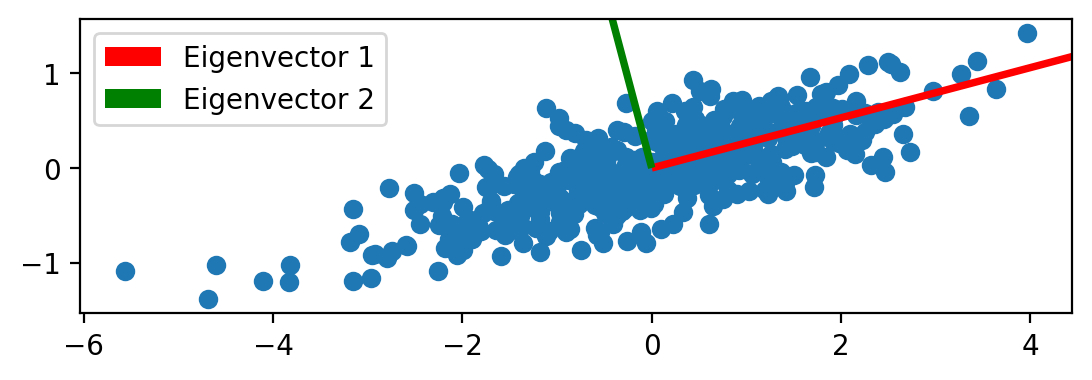

In [92]:
# Plot the eigenvectors along with length of eigenvalues
plt.scatter(X[:,0], X[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(0, 0, eigenvectors[0, 0], eigenvectors[1, 0], scale=eigenvalues[0].sqrt().item(), color='red', label='Eigenvector 1')
plt.quiver(0, 0, eigenvectors[0, 1], eigenvectors[1, 1], scale=eigenvalues[1].sqrt().item(), color='green', label='Eigenvector 2')
plt.legend()


In [94]:
k = 1
Z = torch.matmul(X, eigenvectors[:, :k])
Z.shape

torch.Size([500, 1])

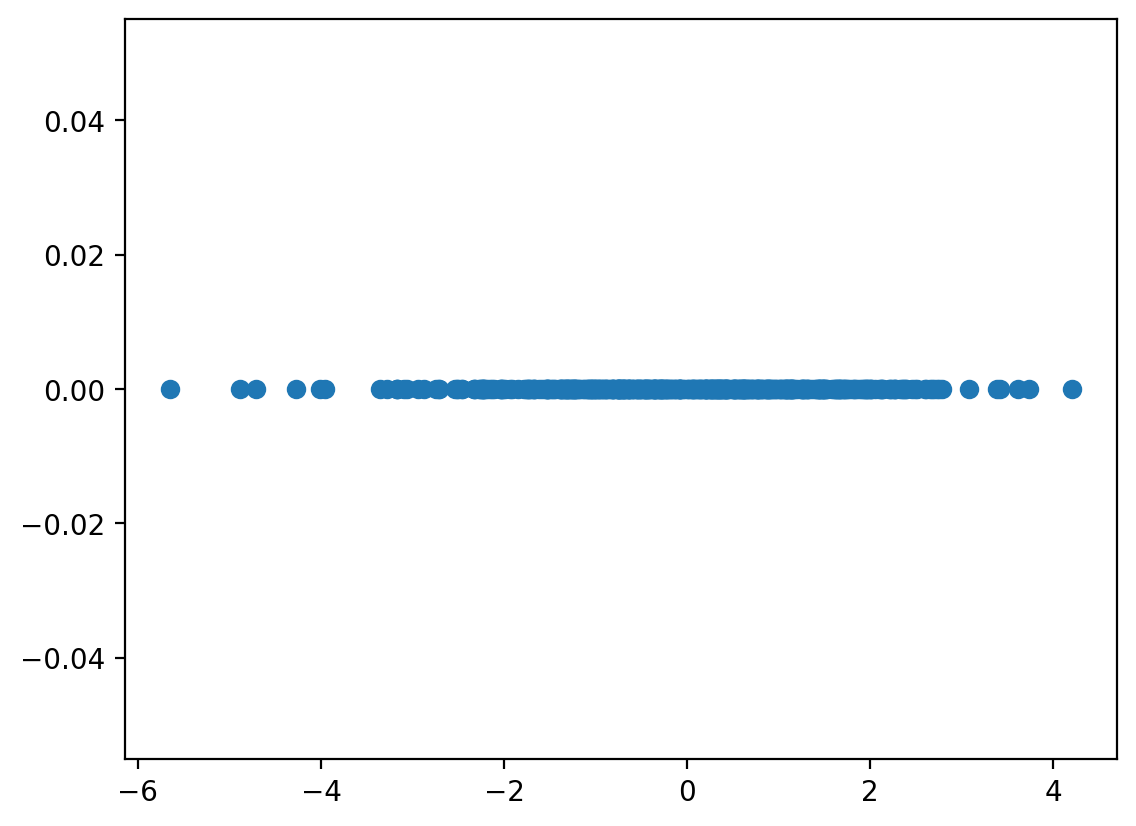

In [95]:
plt.plot(Z, torch.zeros_like(Z), 'o')

In [93]:
# Step 4: Sort eigenvectors based on eigenvalues
sorted_indices = torch.argsort(eigenvalues[:, 0], descending=True)
sorted_eigenvectors = eigenvectors[:, sorted_indices]


IndexError: too many indices for tensor of dimension 1

In [ ]:
sorted

In [104]:
X.mean(dim=0), X.var(dim=0)

(tensor([-5.7220e-09,  0.0000e+00]), tensor([1.9740, 0.2127]))

In [105]:
k = 1  # Number of principal components
B = nn.Parameter(torch.randn(D, k))

In [106]:
B.shape, X.shape

(torch.Size([2, 1]), torch.Size([500, 2]))

In [107]:
mse_loss = nn.MSELoss()

optimizer = optim.Adam([B], lr=0.001) 
num_epochs = 2000  # Number of optimization epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Project data onto the current projection matrix
    z = torch.matmul(X, B)
    x_reconstructed = torch.matmul(z, B.t())
    
    # Compute reconstruction loss
    loss = mse_loss(x_reconstructed, X)
    
    # Perform backpropagation and optimization step
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/2000], Loss: 0.7209210395812988
Epoch [200/2000], Loss: 0.6048457026481628
Epoch [300/2000], Loss: 0.5128658413887024
Epoch [400/2000], Loss: 0.42206627130508423
Epoch [500/2000], Loss: 0.3365266025066376
Epoch [600/2000], Loss: 0.26167812943458557
Epoch [700/2000], Loss: 0.2000642865896225
Epoch [800/2000], Loss: 0.1518339067697525
Epoch [900/2000], Loss: 0.11567910760641098
Epoch [1000/2000], Loss: 0.08960824459791183
Epoch [1100/2000], Loss: 0.07147730886936188
Epoch [1200/2000], Loss: 0.059300925582647324
Epoch [1300/2000], Loss: 0.0514017716050148
Epoch [1400/2000], Loss: 0.0464538112282753
Epoch [1500/2000], Loss: 0.04346401244401932
Epoch [1600/2000], Loss: 0.04172360897064209
Epoch [1700/2000], Loss: 0.0407492071390152
Epoch [1800/2000], Loss: 0.040225498378276825
Epoch [1900/2000], Loss: 0.03995582088828087
Epoch [2000/2000], Loss: 0.039823081344366074


In [108]:
# Project data onto the learned projection matrix
Z = torch.matmul(X, B)

In [110]:
B

Parameter containing:
tensor([[-0.9645],
        [-0.2663]], requires_grad=True)

In [202]:
def train_linear_autoencoder(X, K=2, lr=0.001, num_epochs=2000):
    D = X.size(1)
    B = nn.Parameter(torch.randn(D, K))
    
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam([B], lr=lr)
    num_epochs = num_epochs
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        z = torch.matmul(X, B)
        x_reconstructed = torch.sigmoid(torch.matmul(z, B.t()))
        
        loss = mse_loss(x_reconstructed, X)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    
    return B

In [203]:
# Get MNIST data
from torchvision import datasets
from torchvision.transforms import ToTensor

mnist_train = datasets.MNIST(root='~/.datasets', train=True, transform=ToTensor(), download=True)

In [204]:
X = mnist_train.data.float()
X = X.view(X.size(0), -1)
X = X / 255.0

X.shape

torch.Size([60000, 784])

In [205]:
# Work with first 1000 samples
X = X[:3000]

In [207]:
X.min(), X.max()

(tensor(0.), tensor(1.))

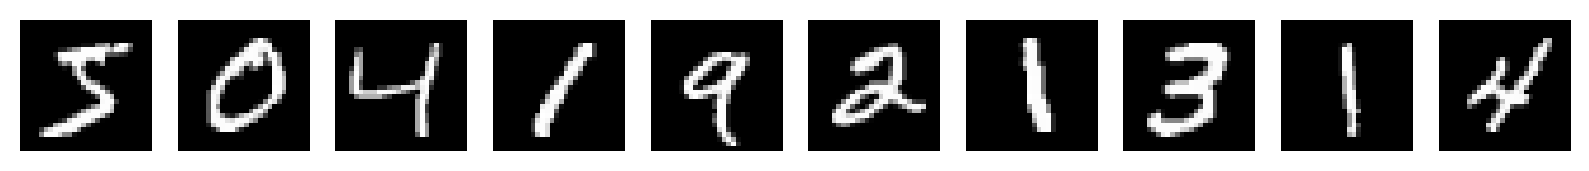

In [208]:
# Plot the first 10 images
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(X[i].view(28, 28).numpy(), cmap='gray')
    ax[i].axis('off')


In [221]:
B = train_linear_autoencoder(X, K=5, lr=0.001, num_epochs=2000)

Epoch [100/2000], Loss: 0.4135352075099945
Epoch [200/2000], Loss: 0.3644017279148102
Epoch [300/2000], Loss: 0.3089104890823364
Epoch [400/2000], Loss: 0.26013466715812683
Epoch [500/2000], Loss: 0.22550225257873535
Epoch [600/2000], Loss: 0.20584215223789215
Epoch [700/2000], Loss: 0.19726672768592834
Epoch [800/2000], Loss: 0.1943318247795105
Epoch [900/2000], Loss: 0.1914585679769516
Epoch [1000/2000], Loss: 0.18916504085063934
Epoch [1100/2000], Loss: 0.18805715441703796
Epoch [1200/2000], Loss: 0.18697765469551086
Epoch [1300/2000], Loss: 0.18595127761363983
Epoch [1400/2000], Loss: 0.18386924266815186
Epoch [1500/2000], Loss: 0.1826687455177307
Epoch [1600/2000], Loss: 0.18168936669826508
Epoch [1700/2000], Loss: 0.18077248334884644
Epoch [1800/2000], Loss: 0.17985987663269043
Epoch [1900/2000], Loss: 0.17898057401180267
Epoch [2000/2000], Loss: 0.17811761796474457


In [222]:
B.shape

torch.Size([784, 5])

In [223]:
# Project data onto the 2d space
with torch.no_grad():
    Z = torch.matmul(X, B)
    X_reconstructed = torch.sigmoid(torch.matmul(Z, B.t()))



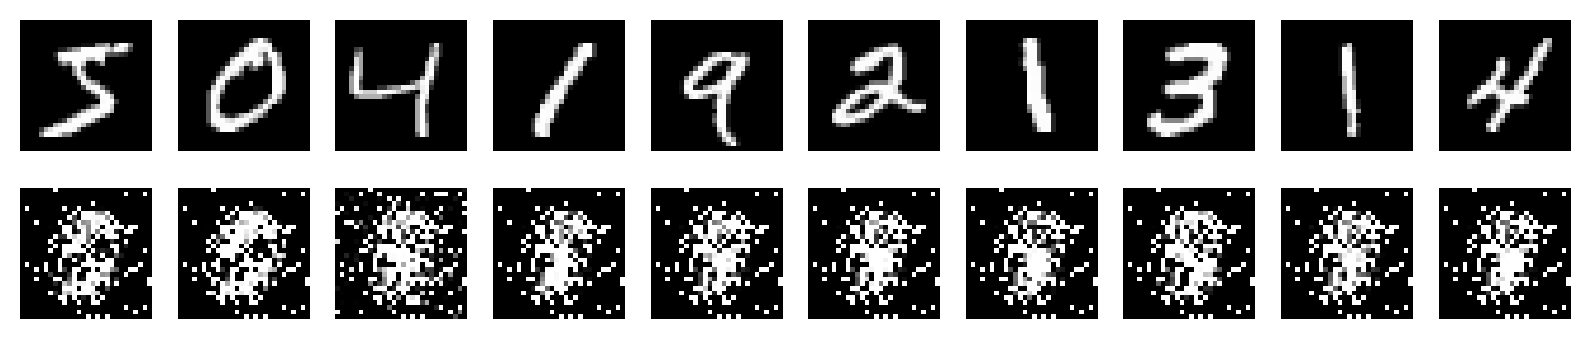

In [224]:
# Plot the first 10 images and their reconstructions
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    ax[0, i].imshow(X[i].view(28, 28).numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(X_reconstructed[i].view(28, 28).numpy(), cmap='gray')
    ax[1, i].axis('off')


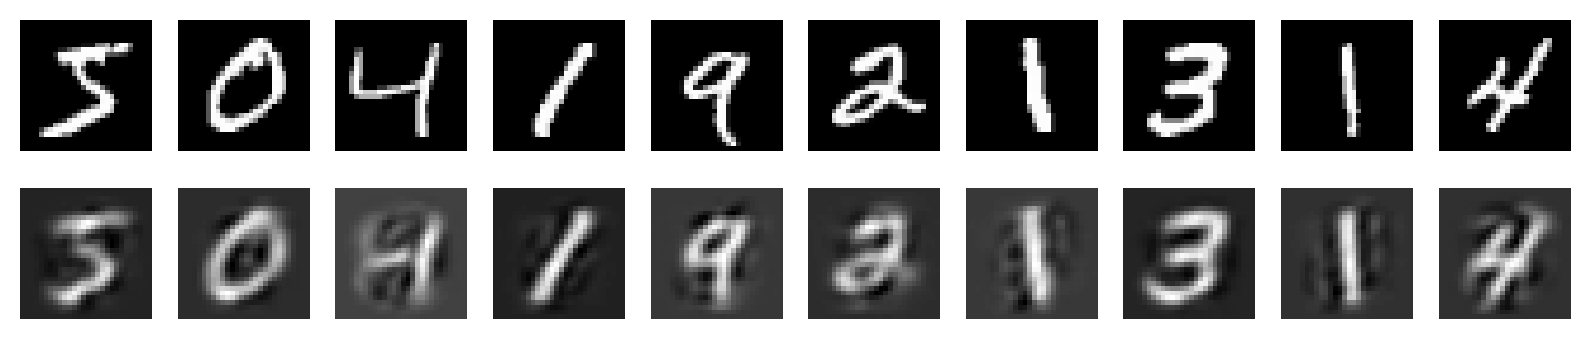

In [229]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)

Z_pca = pca.fit_transform(X.numpy())

X_reconstructed_pca = pca.inverse_transform(Z_pca)

# Plot the first 10 images and their reconstructions
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    ax[0, i].imshow(X[i].view(28, 28).numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(X_reconstructed_pca[i].reshape(28, 28), cmap='gray')
    ax[1, i].axis('off')

In [230]:
import pandas as pd

df = pd.DataFrame({"X": X[0], "X_reconstructed": X_reconstructed[0], "X_reconstructed_pca": X_reconstructed_pca[0]})

<Axes: >

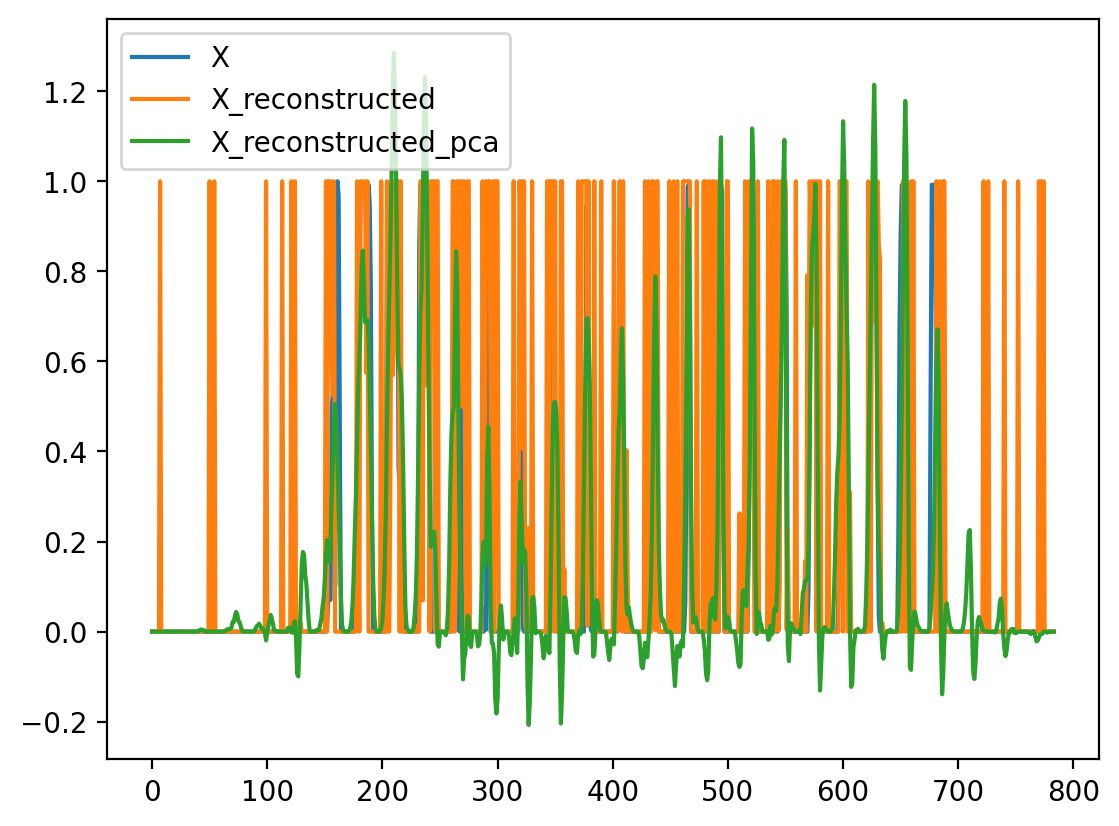

In [231]:
df.plot()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

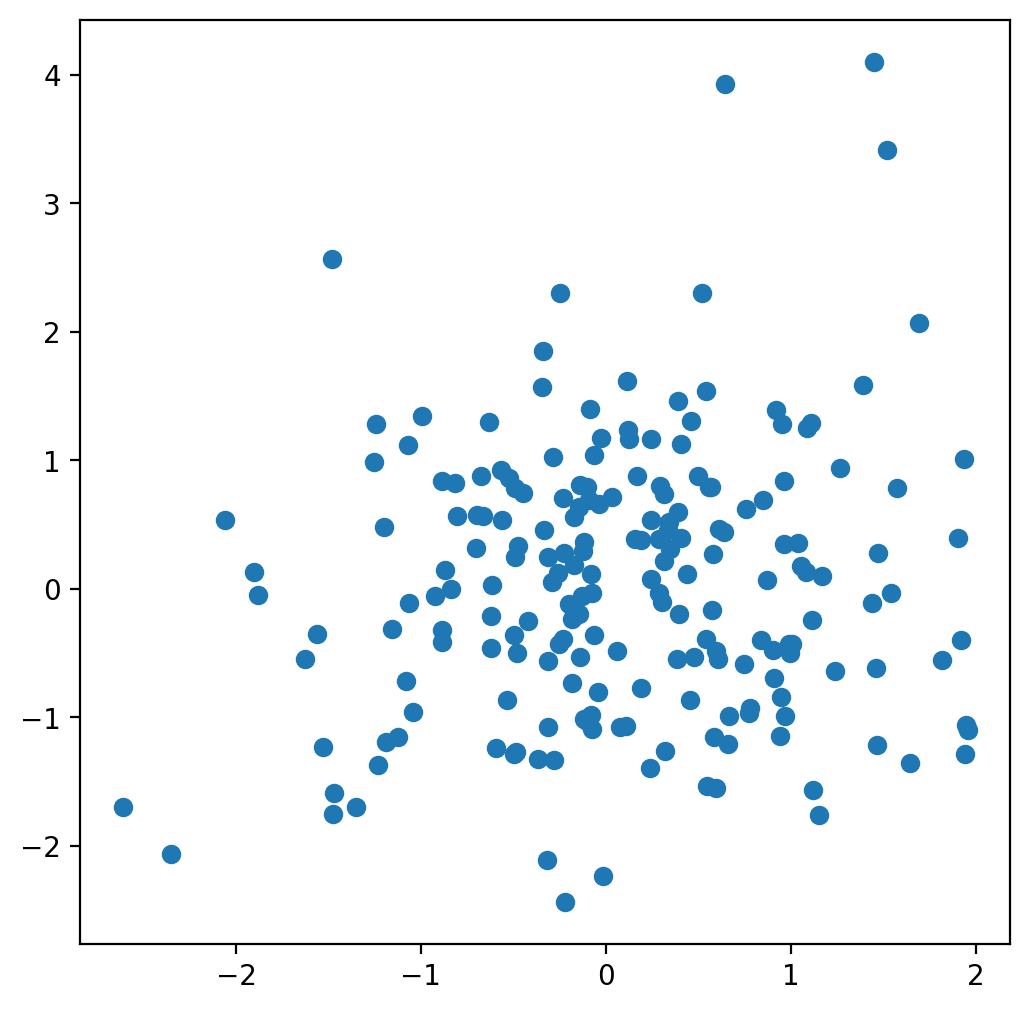

In [25]:
# Plot the original data and the projected data
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], label='Original data')
plt.scatter(Z[:,0], Z[:,0], label='Projected data')